# Welcome to the `tell` Quickstarter! 

### **`tell` is an open-source Python package for projecting future electricty demand in the United States.**

## A little about `tell`

The Total ELectricity Load (TELL) model projects the short- and long-term evoluation of hourly electricity demand (load) in response to future changes in weather and climate. The purpose of `tell` is to generate end-of-century hourly profiles of electricity demand across the entire Conterminous United States (CONUS) at a spatial resolution adequate for input to a unit commitment/economic dispatch (UC/ED) model while also maintaining consistency with the long-term growth and evolution of annual state-level electricity demand projected by an economically driven human-Earth system model. `tell` takes as input future projections of the hourly time-series of meteorology and decadal populations and uses the temporal variations in weather to project hourly profiles of total electricity demand. The core predictions in `tell` are based on a series of multilayer perceptron (MLP) models for individual Balancing Authorities (BAs). Those MLP models are trained on historical observations of weather and electricity demand. Hourly projections from `tell` are scaled to match the annual state-level total electricity loads projected by the U.S. version of the Global Change Analysis Model (GCAM-USA). GCAM-USA captures the long-term co-evolution of the human-Earth system. Using this unique approach allows `tell` to reflect both changes in the shape of the load profile due to variations in weather and the long-term evolution of energy demand due to changes in population, technology, and economics. `tell` is unique from other load forecasting models in that it features an explicit spatial component that allows us to relate projected loads to where they would occur spatially within a grid operations model. The output of `tell` is a series of hourly projections for future electricity demand at the county, state, and BA scale that are quantitatively and conceptually consistent with one another. More information about how the model works and how it can be applied are available on the [Read the Docs](https://immm-sfa.github.io/tell/) site for `tell`.

## Lets get started! 

In this quickstarter we will walk through a series of steps for exploring `tell`, starting with importing the package and ending with visualizing the output. This quickstarter is based on a subset of example forcing data for `tell`. This allows the user to walk through the entire `tell` package in a matter of minutes. For the visualizations throughout this notebook, the user can choose whether or not to save these plots by setting the `save_images` and `image_resolution` flags in each function.

## 1. Install `tell`

`tell` is available via GitHub repository by using the pip install functionality.

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell


## 2. Install the package of data underpinning `tell`

`tell` is based on open-source publicly accessible data. For convienence, we've packaged all of the data underpinning the `tell` quickstarter notebook into a [Zenodo data package](https://zenodo.org/records/13344957). In order to run this notebook, first set the local directory where you would like to store the package data and the run the `install_quickstarter_data` function below. Note that the quickstarter data package will require ~650 MB of storage and can take several minutes to download. You will also need a dataset with sample forcing data for `tell`, also available in a [Zenodo data package](https://zenodo.org/records/13344803). The sample forcing data package will require ~250 MB of storage.

In [2]:
# Identify the current working directory, the subdirectory where the data will be stored, and the image output subdirectory:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')
tell_image_dir = os.path.join(tell_data_dir, r'visualizations')

# If the "tell_data_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)

# If the "tell_image_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_image_dir):
   os.makedirs(tell_image_dir)


In [3]:
# Download the TELL quickstarter data package from Zenodo:
tell.install_quickstarter_data(data_dir = tell_data_dir)


Done!


In [4]:
# Download the TELL sample forcing data package from Zenodo:
tell.install_sample_forcing_data(data_dir = tell_data_dir)


Done!


## 3. MLP model training and projection

This section of the notebook takes the data processed in the `tell_data_preprocessing.ipynb` notebook and trains a multilayer perceptron (MLP) model for each of the 54 BAs in `tell`. The MLP models use temporal variations in weather to project hourly demand. More information about this approach is in the MLP section of the `tell` [User Guide](https://immm-sfa.github.io/tell/user_guide.html). We include pre-trained models within the `tell` repository. If you want to explore the model training aspect you can use the code in Section 3.1 to retrain the MLP models for a single BA or a batch of BAs. Note that since the `save_model` parameter is set to false by default running these training steps will not overwrite the models included in `tell`. If you want to skip this step you can move to Section 3.2 to see how `tell` projects future loads by BA using weather projections.

### 3.1. MLP training
The first step is to train the MLP models using the historical weather and load datasets. The default settings for the MLP model training steps are included in the `mlp_settings.yml` file included in the data folder of the `tell` repository. By default the MLP models are trained on data from 2016-2018 and evaluated using data from 2019. The time windows for training and evaluating the models can be modified by altering the `start_time`, `end_time`, and `split_datetime` parameters when calling the `tell.train` function. The first code block shows how to train the MLP models for a single BA. We also include a function to do some basic analysis of the trained model's performance. More extensive evaluation of the `tell` predictive models is included in the `tell_mlp_calibration_evaluation.ipynb` notebook. The following statistical values, all computed using the sklearn package, are used to evaluate the MLP models:

| Parameter | Description | Documentation |
| :-: | :- | :-: |
| R2 | Coefficient of determination | [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) |
| RMS_ABS | Root-mean-squared of the absolute error | [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) |
| RMS_NORM| The RMS_ABS value divided by the mean | [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) |
| MAPE| Mean absolute percentage error | [sklearn.metrics.mean_absolute_percentage_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error) |

In [5]:
# For more information about the training of predictive models you can call the help function:
help(tell.train)


Help on function train in module tell.mlp_train:

train(region: str, data_dir: str, **kwargs)
    Generate predictions for MLP model for a target region from an input CSV file.
    
    :param region:                      Indicating region / balancing authority we want to train and test on.
                                        Must match with string in CSV files.
    :type region:                       str
    
    :param data_dir:                    Full path to the directory that houses the input CSV files.
    :type data_dir:                     str
    
    :param mlp_hidden_layer_sizes:      The ith element represents the number of neurons in the ith hidden layer.
    :type mlp_hidden_layer_sizes:       Optional[int]
    
    :param mlp_max_iter:                Maximum number of iterations. The solver iterates until convergence
                                        (determined by ‘tol’) or this number of iterations. For stochastic solvers
                                     

In [6]:
# Run the MLP training step for a single BA (i.e., "region"):
prediction_df, validation_df = tell.train(region = 'PJM',
                                          data_dir = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'compiled_historical_data'))

# View the head of the prediction dataframe that contains the time-series of projected load in the evaluation year:
display(prediction_df.head(10))

# View validation dataframe that contains error statistics for the trained model:
validation_df


,datetime,predictions,ground_truth,region
0,2019-01-01 00:00:00,88979.657613,94016.0,PJM
1,2019-01-01 01:00:00,85737.057386,90385.0,PJM
2,2019-01-01 02:00:00,82919.012268,86724.0,PJM
3,2019-01-01 03:00:00,79846.214990,82978.0,PJM
4,2019-01-01 04:00:00,76893.084059,79536.0,PJM
5,2019-01-01 05:00:00,73983.056433,76608.0,PJM
6,2019-01-01 06:00:00,71563.065721,73926.0,PJM
7,2019-01-01 07:00:00,69222.882840,72062.0,PJM
8,2019-01-01 08:00:00,68783.484984,70756.0,PJM
9,2019-01-01 09:00:00,69488.921828,69515.0,PJM


,BA,RMS_ABS,RMS_NORM,MAPE,R2
0,PJM,4384.157491,0.047989,0.036301,0.923456


You can also train multiple BAs at the same time using parallel processing. The example code block below retrains the models for all BAs in `tell`.

In [7]:
# Generate a list of BA abbreviations to process:
ba_abbrev_list = tell.get_balancing_authority_to_model_dict().keys()

# Run the MLP training step for the list of BAs using parallel processing streams:
prediction_df, validation_df = tell.train_batch(target_region_list = ba_abbrev_list,
                                                data_dir = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'compiled_historical_data'),
                                                n_jobs = -1)

# View the validation dataframe that contains error statistics for the trained models:
validation_df


,BA,RMS_ABS,RMS_NORM,MAPE,R2
0,AEC,43.182333,0.080527,0.060206,0.895177
0,AECI,349.811003,0.130529,0.133922,0.652215
0,AVA,162.161834,0.110138,0.108262,0.681471
0,AZPS,226.108856,0.066803,0.052413,0.948951
0,BANC,119.132254,0.062582,0.045901,0.918882
0,BPAT,289.193302,0.045355,0.034236,0.902667
0,CHPD,28.805568,0.136962,0.084884,0.758776
0,CISO,2144.139480,0.087673,0.064678,0.775649
0,CPLE,511.961396,0.072310,0.055798,0.894201
0,DOPD,29.164507,0.141334,0.142977,0.475714


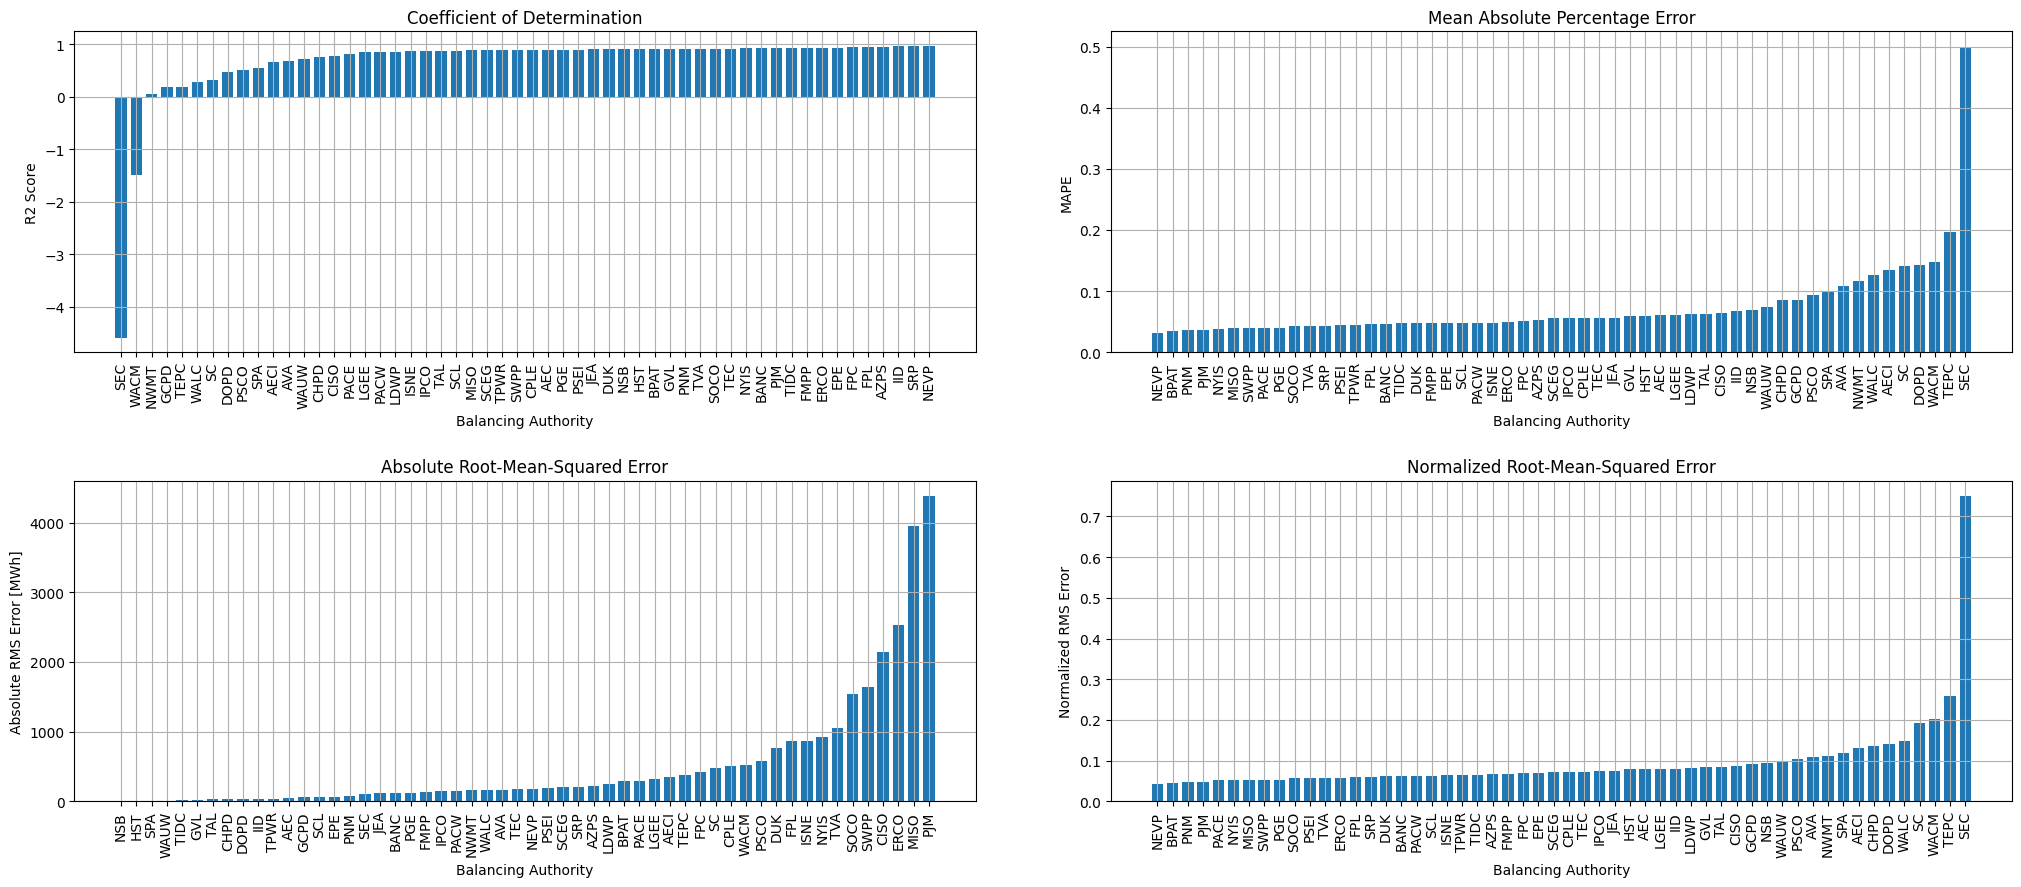

In [8]:
# Plot the statistical performance (e.g., RMS_ABS, RMS_NORM, MAPE, or R2) of the predictive models across all the BAs in TELL:
tell.plot_mlp_summary_statistics(validation_df, 
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = True)


### 3.2. MLP model projection
Next we use the trained MLP models to project future loads in each BA using the sample forcing data downloaded in Section 2. The outcomes of this projection step are then used in the forward execution of `tell` in Section 4. The sample forcing data includes four years of future meteorology for each BA: 2039, 2059, 2079, and 2099. Those are the only valid options for the `year` variable when calling the prediciton functions.

In [9]:
# Run the MLP prediction step for a single BA (i.e., "region"):
pdf = tell.predict(region = 'ERCO',
                   year = 2039,
                   data_dir = os.path.join(tell_data_dir, r'sample_forcing_data', r'future_weather', r'rcp85hotter_ssp5'),
                   datetime_field_name = 'Time_UTC',
                   save_prediction = True,
                   prediction_output_directory = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'mlp_output', r'rcp85hotter_ssp5'))

# View the prediction dataframe:
pdf


,Time_UTC,Load,BA
0,2039-01-01 00:00:00,35834.03,ERCO
1,2039-01-01 01:00:00,35952.67,ERCO
2,2039-01-01 02:00:00,36656.28,ERCO
3,2039-01-01 03:00:00,35927.32,ERCO
4,2039-01-01 04:00:00,34359.22,ERCO
...,...,...,...
8755,2039-12-31 19:00:00,33714.60,ERCO
8756,2039-12-31 20:00:00,33807.07,ERCO
8757,2039-12-31 21:00:00,34015.67,ERCO
8758,2039-12-31 22:00:00,34544.19,ERCO


In [10]:
# Generate a list of BA abbreviations to process:
ba_abbrev_list = tell.get_balancing_authority_to_model_dict().keys()

# Run the MLP prediction step for the list of BAs using parallel processing streams:
pdf = tell.predict_batch(target_region_list = ba_abbrev_list,
                         year = 2039,
                         data_dir = os.path.join(tell_data_dir, r'sample_forcing_data', r'future_weather', r'rcp85hotter_ssp5'),
                         datetime_field_name = 'Time_UTC',
                         save_prediction = True,
                         prediction_output_directory = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'mlp_output', r'rcp85hotter_ssp5'),
                         n_jobs = -1)

# View the prediction dataframe:
pdf


,Time_UTC,Load,BA
0,2039-01-01 00:00:00,540.18,AEC
1,2039-01-01 01:00:00,581.78,AEC
2,2039-01-01 02:00:00,597.64,AEC
3,2039-01-01 03:00:00,586.73,AEC
4,2039-01-01 04:00:00,567.86,AEC
...,...,...,...
8755,2039-12-31 19:00:00,84.82,WAUW
8756,2039-12-31 20:00:00,85.39,WAUW
8757,2039-12-31 21:00:00,85.42,WAUW
8758,2039-12-31 22:00:00,85.65,WAUW


## 4. Model forward execution

This section of the `tell` workflow takes the .csv files produced by the `tell` MLP models and distributes the projected load to the counties that each BA operates in. The county-level hourly loads are then summed to the state-level and scaled to match the state-level annual loads produced by GCAM-USA. The year to scale against the GCAM estimates can be controlled using the `gcam_target_year` flag. Four sets of output files are generated: county-level hourly loads, state-level hourly loads, hourly loads for each BA, and a summary file that includes state-level annual loads from TELL and GCAM-USA as well as the scaling factors. Note that since it takes a while to write out the county-level output data this output is optional. To output county-level load projections just set the `save_county_data` flag to true.

In [11]:
# Run the TELL model forward in time for a given year:
summary_df, ba_time_series_df, state_time_series_df = tell.execute_forward(year_to_process = '2039',
                                                                           gcam_target_year = '2039', 
                                                                           scenario_to_process = 'rcp85hotter_ssp5',
                                                                           data_output_dir = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'tell_output'),
                                                                           gcam_usa_input_dir = os.path.join(tell_data_dir, r'sample_forcing_data', r'sample_gcam_usa_data'),
                                                                           map_input_dir = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'ba_service_territory'),
                                                                           mlp_input_dir = os.path.join(tell_data_dir, r'tell_quickstarter_data', r'outputs', r'mlp_output'),
                                                                           pop_input_dir = os.path.join(tell_data_dir, r'sample_forcing_data', r'sample_population_projections'),
                                                                           save_county_data = False)


Scenario =  rcp85hotter_ssp5 , Year =  2039
Elapsed time =  0:00:57.915849


## 5. Model visualization

The final section of this quickstarter notebook plots some of the output of `tell` to give the user a flavor of what the model is doing. Note that the sample output data in the `tell` quickstarter covers the years 2039, 2059, 2079, and 2099 so those are the only valid values for the `year_to_plot` variable in each function call.

### 5.1. Plot the state annual total loads from GCAM-USA and `tell`

The first visualization plots the annual total loads from both GCAM-USA and `tell`. The data plotted here are in units of TWh and the `tell` values are the unscaled projections. The scaled projections `tell` are by definition equal to those from GCAM-USA.

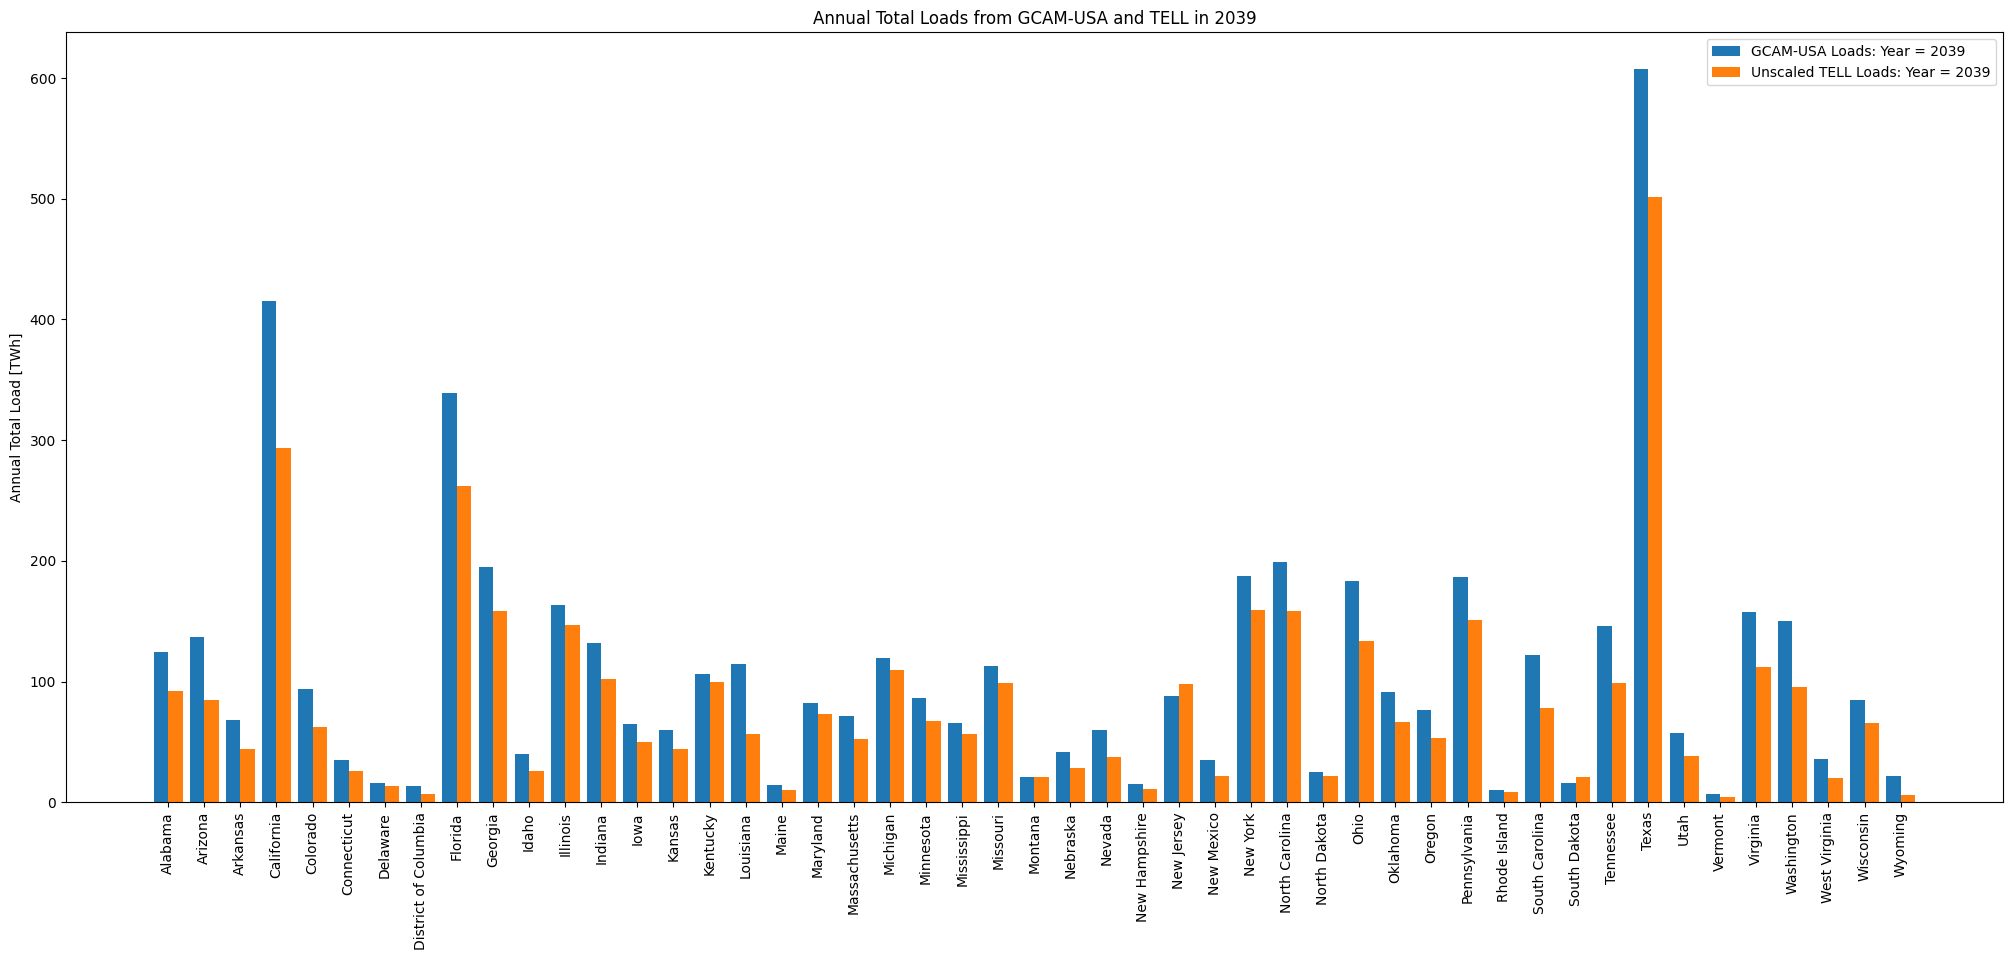

In [12]:
# Plot the annual total loads from both GCAM-USA and TELL:
tell.plot_state_annual_total_loads(year_to_plot = '2039',
                                   gcam_target_year = '2039',
                                   scenario_to_plot = 'rcp85hotter_ssp5',  
                                   data_input_dir = tell_data_dir,
                                   image_output_dir = tell_image_dir,
                                   image_resolution = 150,
                                   save_images = True)


### 5.2. Plot the time-series of total hourly loads for a given state

Here we plot time-series of the raw (unscaled) and scaled total loads from `tell` at the state level. The user specifies which state they want to plot using the `state_to_plot" variable in the function call.

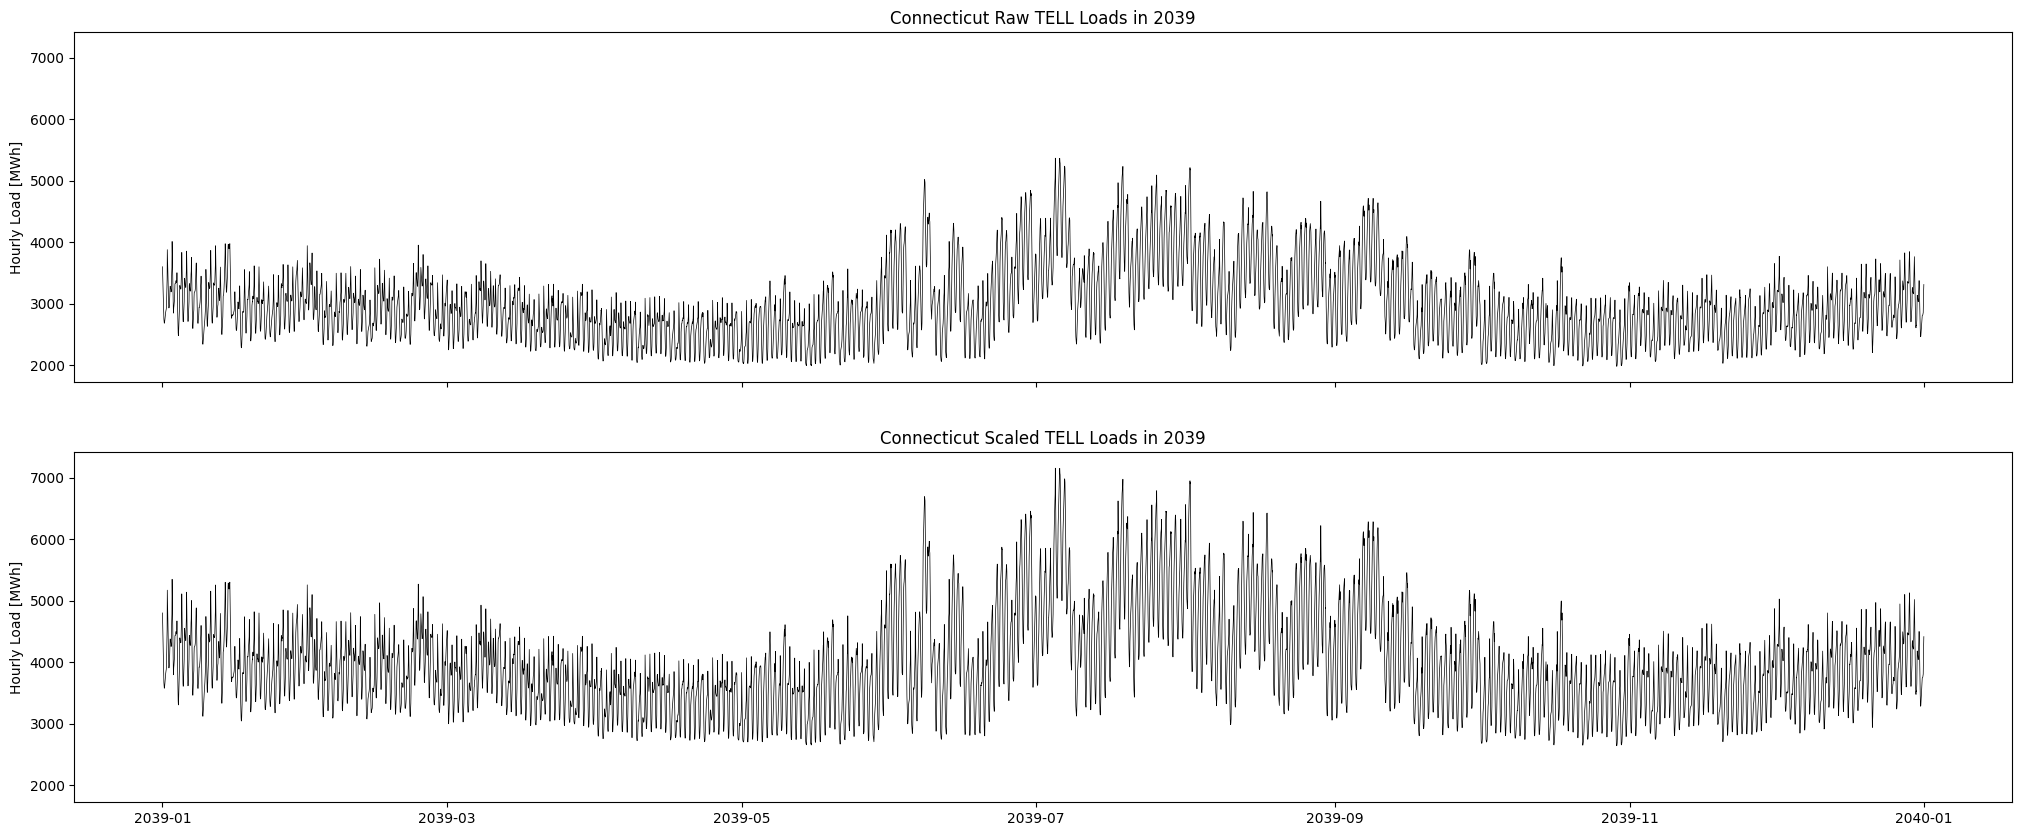

In [13]:
# Plot the time-series of raw and scaled loads from TELL at the state level for a user-specified state:
tell.plot_state_load_time_series(state_to_plot = 'Connecticut', 
                                 year_to_plot = '2039',
                                 gcam_target_year = '2039',
                                 scenario_to_plot = 'rcp85hotter_ssp5', 
                                 data_input_dir = tell_data_dir,
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = True)


### 5.3. Plot the load duration curve for a given state

Our last plot at the state level is the load duration curve which shows the frequency at which a given load occurs in a state. The user specifies which state they want to plot using the "state_to_plot" variable in the function call.

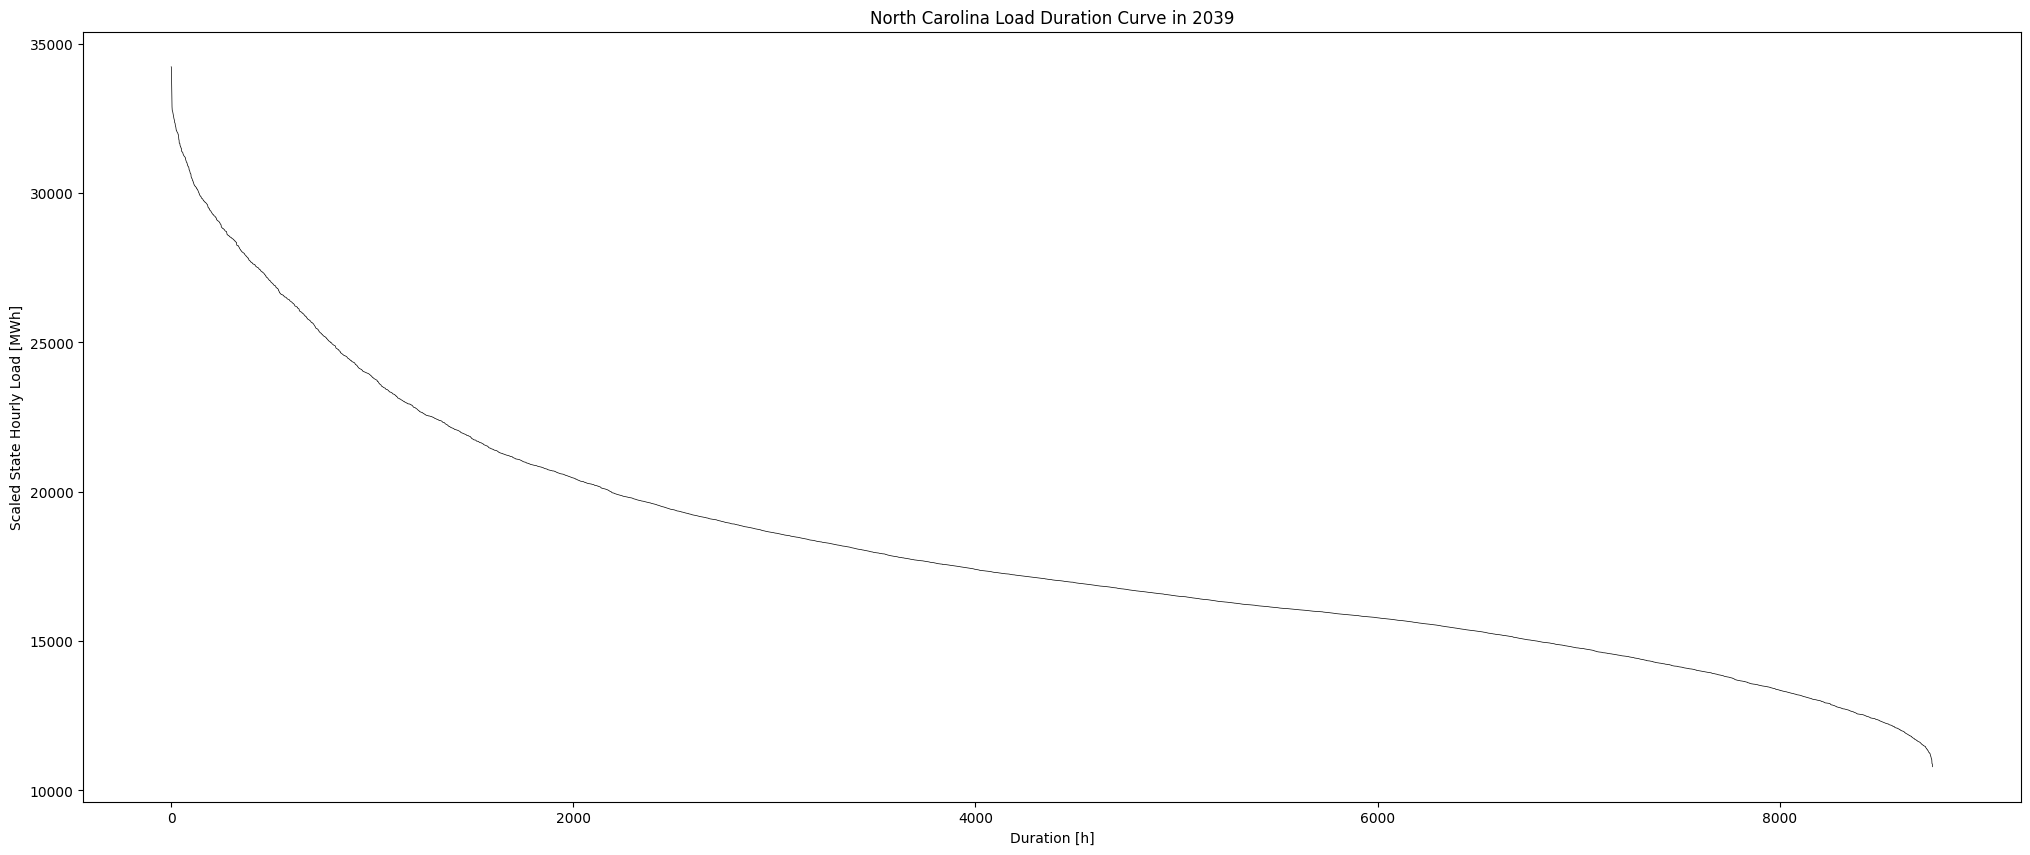

In [14]:
# Plot the load duration curve at the state level for a user-specified state:
tell.plot_state_load_duration_curve(state_to_plot = 'North Carolina', 
                                    year_to_plot = '2039',
                                    gcam_target_year = '2039',
                                    scenario_to_plot = 'rcp85hotter_ssp5', 
                                    data_input_dir = tell_data_dir,
                                    image_output_dir = tell_image_dir,
                                    image_resolution = 150,
                                    save_images = True)


### 5.4. Plot the time-series of total hourly loads for a given BA

Our final visualization plots the time-series of the raw (unscaled) and scaled total loads from `tell` at the BA level. The user specifies which BA they want to plot using the "ba_to_plot" variable in the function call.

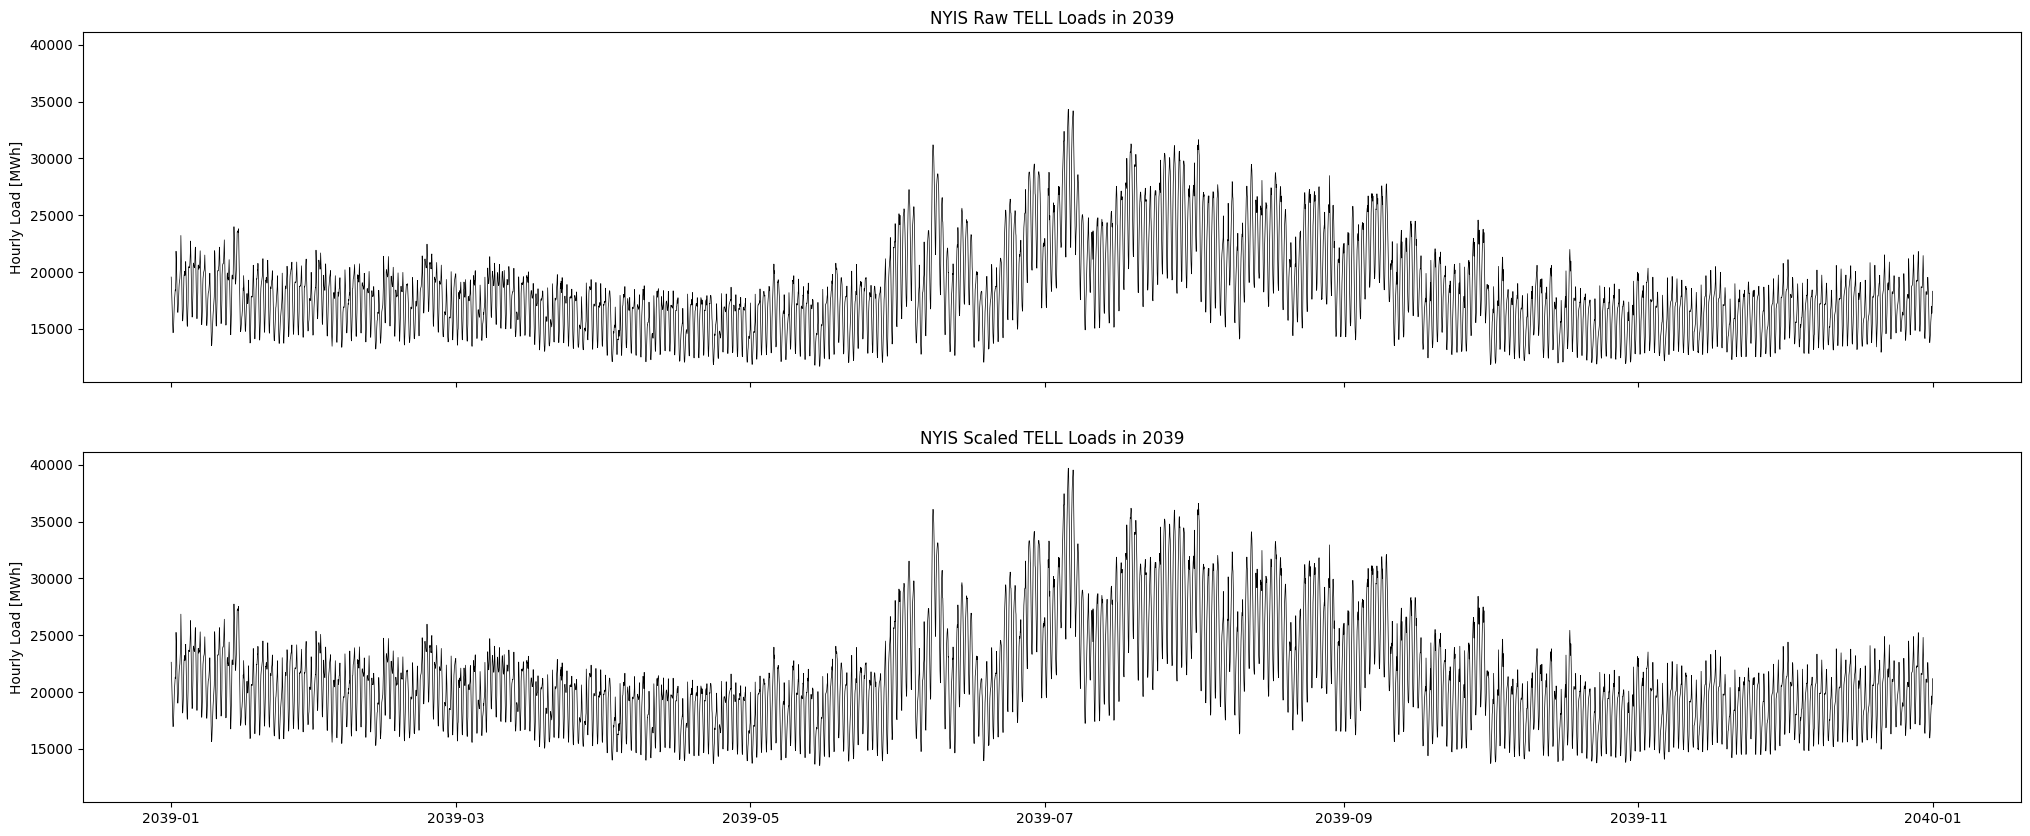

In [15]:
# Plot the time-series of raw and scaled loads from TELL at the BA level for a user-specified BA (e.g., PJM, CISO, ERCO, etc.):
tell.plot_ba_load_time_series(ba_to_plot = 'NYIS', 
                              year_to_plot = '2039',
                              gcam_target_year = '2039',
                              scenario_to_plot = 'rcp85hotter_ssp5', 
                              data_input_dir = tell_data_dir,
                              image_output_dir = tell_image_dir,
                              image_resolution = 150,
                              save_images = True)
